In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten , Conv2D , MaxPooling2D , Dropout, BatchNormalization
from tensorflow.keras.utils import  to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2 as cv
import os
from sklearn.model_selection import train_test_split

2025-07-31 19:09:06.537979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753988946.823693      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753988946.903198      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = "/kaggle/input/gtsrb-german-traffic-sign/Train"
X_train = []
y_train = []
num_corrupted = 0

for label in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, label)
    if not os.path.isdir(folder_path):
        continue

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith(".png"):
            continue
        img_path = os.path.join(folder_path, img_name)
        try:
            img = cv.imread(img_path)
            if img is None:
                num_corrupted += 1
                continue
            img = cv.resize(img, (64, 64))
            X_train.append(img)
            y_train.append(int(label))
        except:
            num_corrupted += 1

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"Number of corrupted images: {num_corrupted}")
print(f"Number of loaded images: {len(X_train)}")
print(f"Number of labels: {len(y_train)}")

Number of corrupted images: 0
Number of loaded images: 39209
Number of labels: 39209


In [3]:
base_path = "/kaggle/input/gtsrb-german-traffic-sign"
csv_path = os.path.join(base_path, "Test.csv")

df = pd.read_csv(csv_path)

X_test = []
y_test = []
num_corrupted = 0

for idx, row in df.iterrows():
    img_rel_path = row["Path"] 
    label = row["ClassId"]

    img_path = os.path.join(base_path, img_rel_path)
    try:
        img = cv.imread(img_path)
        if img is None:
            num_corrupted += 1
            continue
        img = cv.resize(img, (64, 64))
        X_test.append(img)
        y_test.append(label)
    except:
        num_corrupted += 1

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Number of corrupted test images: {num_corrupted}")
print(f"Number of loaded test images: {len(X_test)}")
print(f"Number of test labels: {len(y_test)}")


Number of corrupted test images: 0
Number of loaded test images: 12630
Number of test labels: 12630


In [4]:
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

Number of classes: 43


In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.001, random_state=42, shuffle=True
)

In [6]:
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
X_validation = np.array(X_validation) / 255.0

X_train = X_train.reshape(-1, 64, 64, 3)
X_test = X_test.reshape(-1, 64, 64, 3)
X_validation = X_validation.reshape(-1, 64, 64, 3)

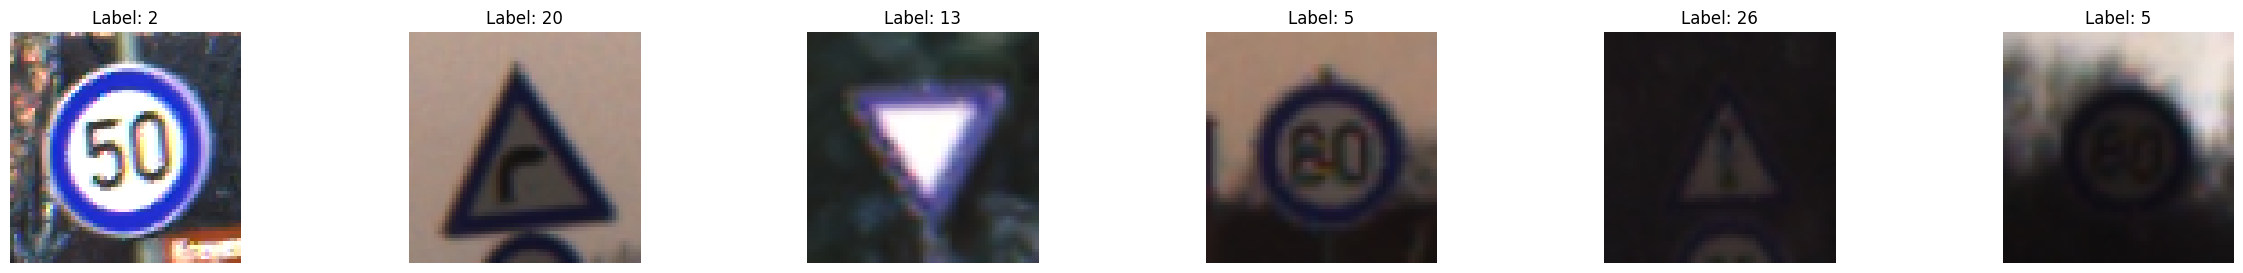

In [7]:
plt.figure(figsize=(30, 3))

for index, (image, label) in enumerate(zip(X_train[0:6], y_train[0:6])):
    plt.subplot(1, 6, index + 1)
    image = image.reshape(64, 64, 3) 
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()


In [8]:
model = Sequential([
    Conv2D(32 , (3,3), activation='relu', input_shape=(64,64,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-31 19:16:09.607100: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [10]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history  = model.fit(
    X_train, y_train, 
    epochs = 15, 
    batch_size = 128, 
    validation_data=(X_validation, y_validation),
    callbacks=[early_stop_cb]
)


Epoch 1/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 270s 863ms/step - accuracy: 0.4629 - loss: 2.1030 - val_accuracy: 0.3750 - val_loss: 2.2980
Epoch 2/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 244s 794ms/step - accuracy: 0.9335 - loss: 0.2134 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 3/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 269s 877ms/step - accuracy: 0.9720 - loss: 0.0864 - val_accuracy: 1.0000 - val_loss: 0.0108
Epoch 4/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 242s 788ms/step - accuracy: 0.9802 - loss: 0.0610 - val_accuracy: 1.0000 - val_loss: 4.5166e-04
Epoch 5/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 238s 776ms/step - accuracy: 0.9868 - loss: 0.0424 - val_accuracy: 1.0000 - val_loss: 9.2658e-04
Epoch 6/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 266s 866ms/step - accuracy: 0.9886 - loss: 0.0348 - val_accuracy: 1.0000 - val_loss: 0.0368
Epoch 7/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 237s 773ms/step - accuracy: 0.9903 - loss: 0.0286 - val_accuracy: 1.0000 - val_loss: 0.0263


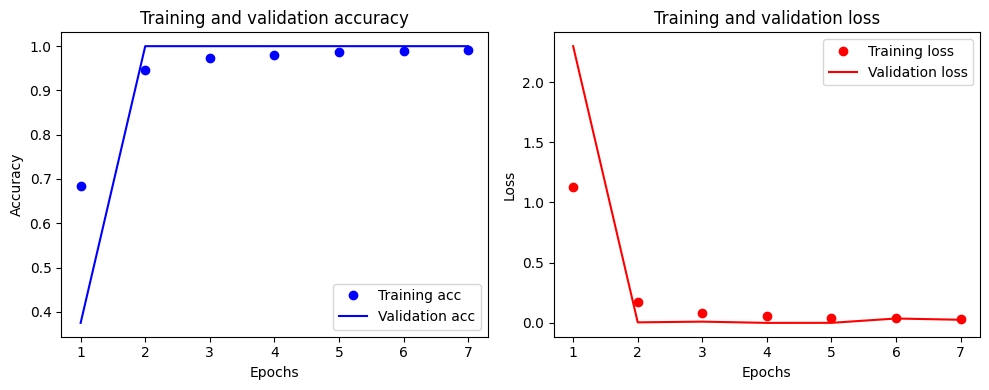

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
predictions = model.predict(X_test)

395/395 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step


In [13]:
results = model.evaluate(X_test, y_test)
print('Test loss, Test Accuracy:', results)

395/395 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9646 - loss: 0.1406
Test loss, Test Accuracy: [0.15371128916740417, 0.9634996056556702]
